# Gradient-Based Optimization

Many problems in science, engineering, and machine learning can be framed as finding the minimum (or maximum) of a function. While there are so-called zeroth-order methods (which just sample the function), they are often very slow. 

This chapter will focus on more powerful *gradient-based* methods:
1.  **First-Order Methods:** Use the gradient (first derivative), $\nabla f(x)$, to find the direction of steepest descent.
2.  **Second-Order Methods:** Use the Hessian matrix (second derivative), $H_f(x)$, to build a quadratic model of the function, which helps us find a more direct path to the minimum.

To test our algorithms, we'll use the following 2D function. We choose it because it's *non-convex* and has many local minima, making it a good challenge for our optimizers.

$$
f(x_1, x_2) = -\sin\left(\frac{x_1^2}{2} - \frac{x_2^2}{4} + 3 \right) \cos\left(2x_1 + 1 -e^{x_2}\right)
$$

Since $f$ only depends on two variables, we can easily visualize it in the plane using a contour plot.

In [1]:
using Plots

function fastdisplay(h=current())
    fname = savefig(h, tempname())
    display("image/png", read(fname))
    rm(fname, force=true)
end

# Define our 2D test function
f(x) = -sin(x[1]^2/2 - x[2]^2/4 + 3) * cos(2*x[1] + 1 - exp(x[2]))

# A helper function to create a contour plot of f
function fplot(f; xlim=(-2.5,2.5), ylim=(-1.5,1.5), levels=25)
    # Create a grid of x1 and x2 values
    x1s = range(xlim[1], xlim[2], 300)
    x2s = range(ylim[1], ylim[2], 200)
    
    # Evaluate f at every (x, y) point on the grid
    # Transpose to make the x-coordinate horizontal
    fs = [f([x1, x2]) for x1 in x1s, x2 in x2s]'
    
    # Create the contour plot
    contourf(x1s, x2s, fs, levels=levels,
             color=:viridis, linecolor=:black,
             aspect_ratio=:equal, size=(800,500))
end

fplot (generic function with 1 method)

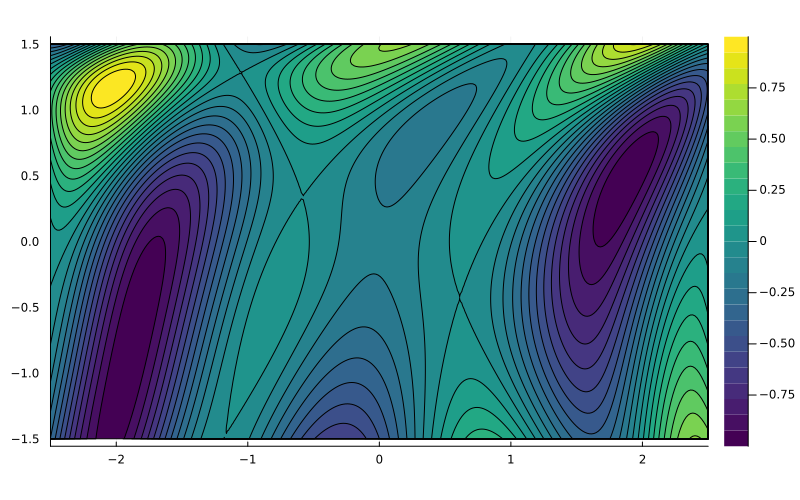

In [2]:
# Plot the function to see the optimization landscape
# The dark blue areas are the local minima we want to find.
fastdisplay(fplot(f))

## Gradient Descent (Fixed Step Size)

The most fundamental optimization algorithm is **gradient descent**. The idea is simple: the gradient $\nabla f(x)$ points in the direction of the *steepest ascent* (where the function increases most). Therefore, the *negative* gradient, $-\nabla f(x)$, points in the direction of **steepest descent**.

We can turn this into an iterative algorithm. Starting from a guess $x_0$, we repeatedly take steps "downhill":

1.  Choose a search direction: $p_k = -\nabla f(x_k)$
2.  Choose a step size: $\alpha$ (a small positive number, e.g., 0.1)
3.  Update our position: $x_{k+1} = x_k + \alpha p_k$

We repeat this for `maxiter` steps or until the magnitude of the gradient
$\|\nabla f(x)\|_2$ is smaller than `tol`.

In [3]:
# Implements the fixed-step gradient descent algorithm
function gradient_descent(f, ∇f, x0, α; maxiter=500, tol=1e-4)
    # Create an array to store the entire path for plotting
    # We initialize it with the starting point, x0
    xs = [x0]
    
    # Take (at most) maxiter steps
    for i = 1:maxiter
        # Get the current position
        xk = xs[end]
        
        # Calculate the search direction (steepest descent)
        pk = -∇f(xk)

        # Check gradient magnitude for termination
        if sqrt(sum(pk.^2)) < tol
            break
        end        
        
        # Take a fixed step α in the search direction
        xk_new = xk + α * pk
        
        # Add the new point to our path
        push!(xs, xk_new)
    end
    return xs
end

gradient_descent (generic function with 1 method)

In [4]:
# Helper function to plot the optimization path on top of the contour plot
function plot_path(xs; label="Path")
    # Extract the x1 and x2 coordinates from the path history
    x1s,x2s = first.(xs), last.(xs)
    
    # Plot the path as a line with markers
    plot!(x1s, x2s, marker=:circle, label=label, linewidth=3, palette=:Pastel1_3)
end

plot_path (generic function with 1 method)

### Using Analytical Gradients

First, we'll test this method using the *analytical* gradient, which we find by calculating the partial derivatives of $f(x)$ by hand (using calculus and the chain rule). This is tedious and error-prone, which will motivate our next section.

In [5]:
# The manually-derived, analytical gradient of f(x)
function ∇f(x)
    x1,x2 = x
    
    # Pre-compute common sub-expressions from the function f(x)
    t1 = x1^2/2 - x2^2/4 + 3
    t2 = 2*x1 + 1 - exp(x2)
    
    # Calculate partial derivative with respect to x1
    df_dx1 = -cos(t1)*x1 * cos(t2) - -sin(t1) * sin(t2)*2
    
    # Calculate partial derivative with respect to x2
    df_dx2 = -cos(t1)*(-x2/2) * cos(t2) - -sin(t1) * sin(t2)*(-exp(x2))
    
    # Return the gradient vector [df/dx1, df/dx2]
    return [df_dx1, df_dx2]
end

∇f (generic function with 1 method)

Path 1: Length=501, ||gradient|| = 1.4715843307921153
Path 2: Length=67, ||gradient|| = 8.918594790414185e-5
Path 3: Length=501, ||gradient|| = 1.7575802156689104


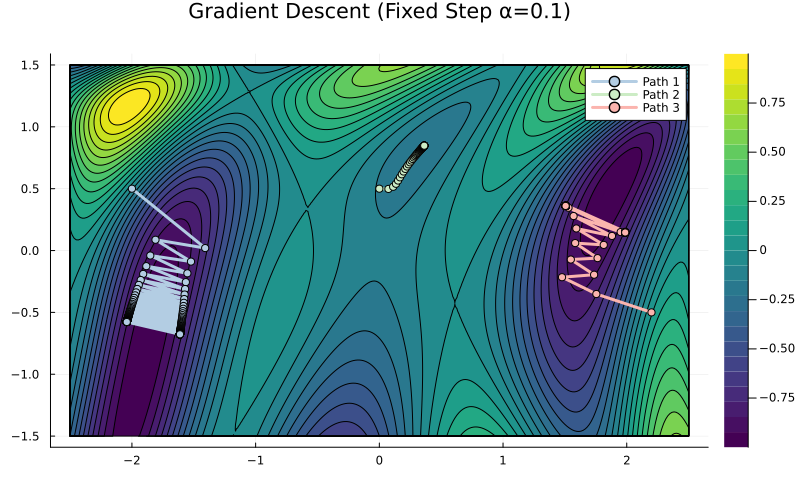

In [6]:
fplot(f)
plot!(title="Gradient Descent (Fixed Step α=0.1)")

# Define three different starting points
x0s = [[-2.0, 0.5], [0.0, 0.5], [2.2, -0.5]]

for (i, x0) in enumerate(x0s)
    # Run the optimizer
    xs = gradient_descent(f, ∇f, x0, 0.3)
    
    # Plot the path
    plot_path(xs, label="Path $i")
    
    # Print the final result
    println("Path $i: Length=$(length(xs)), ||gradient|| = $(sqrt(sum(∇f(xs[end]).^2)))")
end
fastdisplay()

# Note: The paths converge to *different* local minima!
# This is expected for a non-convex function.

### Line Search Methods

A fixed step size $\alpha$ is problematic. If it's too small, the algorithm is very slow. If it's too large, the algorithm can become unstable and *diverge* (overshoot the minimum and end up somewhere with a higher $f$ value).

A better approach is to use a **line search**. At each step $k$, we still find the direction $p_k = -\nabla f(x_k)$, but we then solve a 1D optimization problem to find the *best* $\alpha$ for that direction:

$$
\min_{\alpha > 0} \quad g(\alpha) = f(x_k + \alpha p_k)
$$

Solving this *exactly* is too much work. A common and simple strategy is to start with a small guess for $\alpha$ and repeatedly grow it (e.g., $\alpha = 2\alpha$) until the function value at the target point is not decreasing any longer.

In [7]:
# A simple line search implementation
function line_search(f, x, direction; αmin=1/2^20, αmax=2^20)
    α = αmin      # Start with a small step
    fold = f(x)   # Initial function value

    # Loop as long as it improves or exceeding maximum step size
    while true
        if α ≥ αmax
            return α   # Maximum step size
        end
        # Check if the new point is *better* than the old point
        fnew = f(x + α*direction)
        if fnew ≥ fold
            return α/2   # No improvement, return last value
        else
            fold = fnew  # Improvement, continue increasing α
        end
        α *= 2   # Grow the step size
    end
end

line_search (generic function with 1 method)

In [8]:
# A generic line search optimization algorithm.
# This is the *same* as gradient_descent, but we've generalized it.
# Instead of '∇f', it takes a 'search_dir_func' that computes *any* search direction p_k.

function line_search_optimizer(f, search_dir_func, x0; maxiter=500, tol=1e-4)
    xs = [x0] # Store the path
    
    for i = 1:maxiter
        xk = xs[end]
        
        # Get the search direction from the provided function
        pk = search_dir_func(xk)
        
        # Check gradient magnitude for termination
        if sqrt(sum(pk.^2)) < tol
            break
        end        
        
        # Find the *best* step size α using our line search
        α = line_search(f, xk, pk)
        
        # Take the step
        xk_new = xk + α * pk
        push!(xs, xk_new)
    end
    return xs
end

line_search_optimizer (generic function with 1 method)

Path 1: Length=47, ||gradient|| = 7.870693265014514e-5
Path 2: Length=19, ||gradient|| = 2.707659519760321e-5
Path 3: Length=34, ||gradient|| = 6.996634619625889e-5


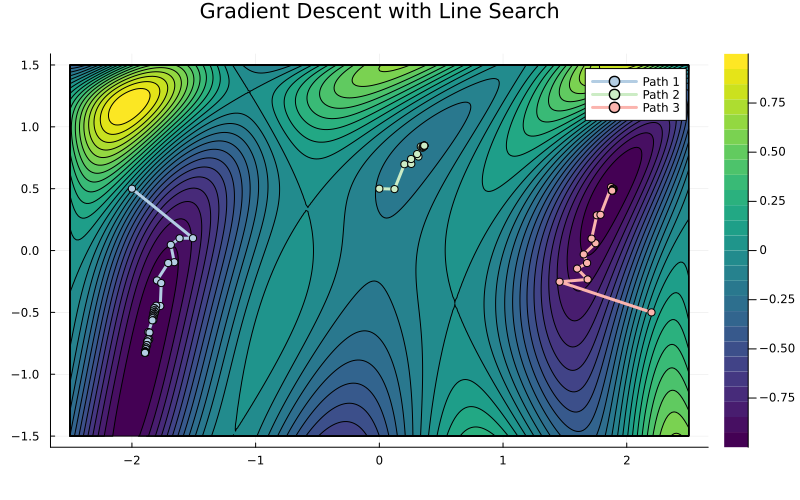

In [9]:
fplot(f)
plot!(title="Gradient Descent with Line Search")

# Use the same starting points
x0s = [[-2.0, 0.5], [0.0, 0.5], [2.2, -0.5]]

for (i, x0) in enumerate(x0s)
    # Call our generic optimizer.
    # The search direction function is just the negative gradient.
    search_dir(x) = -∇f(x)
    xs = line_search_optimizer(f, search_dir, x0)
    
    plot_path(xs, label="Path $i")
    println("Path $i: Length=$(length(xs)), ||gradient|| = $(sqrt(sum(∇f(xs[end]).^2)))")
end
fastdisplay()

# Note: The paths are much more direct and take fewer steps to converge!

### Numerical Gradients (Finite Differences)

Manually calculating the gradient `∇f` was tedious and a source of bugs. We can free ourselves from this by approximating the gradient numerically using **finite differences**.

The partial derivative $\frac{\partial f}{\partial x_i}$ can be approximated by "wiggling" the $i$-th variable, $x_i$, by a tiny amount $h$ and seeing how $f$ changes. We use a *centered difference* formula, which is much more accurate than a simple one-sided one:

$$
\frac{\partial f}{\partial x_i} \approx \frac{f(x + h \cdot e_i) - f(x - h \cdot e_i)}{2h}
$$

where $e_i = [0, \ldots, 1, \ldots, 0]$ is the $i$-th standard basis vector (a 1 in the $i$-th position and 0s elsewhere). We just do this for all $i$ from 1 to $n$ to build the full gradient vector.

In [10]:
# Calculates the gradient of 'f' at 'x' using centered finite differences
function finite_difference_gradient(f, x, h=1e-5)
    n = length(x)       # Get the dimension of x (e.g., 2)
    ∇f = zeros(n)       # Initialize the gradient vector to zeros
    
    # Loop over each dimension i
    for i = 1:n
        # Create the basis vector e_i
        ei = zeros(n)
        ei[i] = 1.0
        
        # Calculate f(x + h*e_i)
        f_plus = f(x + h * ei)
        
        # Calculate f(x - h*e_i)
        f_minus = f(x - h * ei)
        
        # Apply the centered difference formula
        ∇f[i] = (f_plus - f_minus) / (2 * h)
    end
    return ∇f
end

finite_difference_gradient (generic function with 2 methods)

Path 1: Length=47, ||gradient|| = 7.870696143799702e-5
Path 2: Length=19, ||gradient|| = 2.7076774319819133e-5
Path 3: Length=34, ||gradient|| = 6.996618451764213e-5


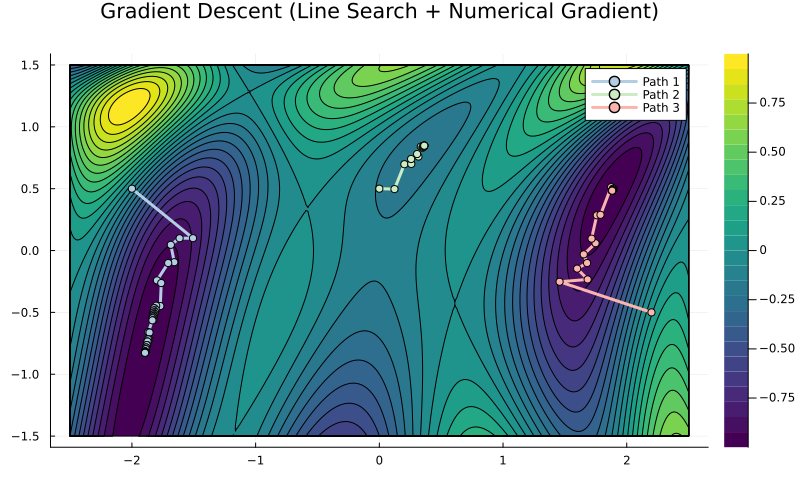

In [11]:
fplot(f)
plot!(title="Gradient Descent (Line Search + Numerical Gradient)")

x0s = [[-2.0, 0.5], [0.0, 0.5], [2.2, -0.5]]

for (i, x0) in enumerate(x0s)
    # This time, our search direction uses the numerical gradient!
    # We don't need the '∇f' function at all.
    search_dir(x) = -finite_difference_gradient(f, x)
    xs = line_search_optimizer(f, search_dir, x0)
    
    plot_path(xs, label="Path $i")
    println("Path $i: Length=$(length(xs)), ||gradient|| = $(sqrt(sum(∇f(xs[end]).^2)))")
end
fastdisplay()

# The results are almost identical to the analytical gradient. Success!

## Newton's Method

Gradient descent is a *first-order* method. It works well, but it can be slow because it only uses the local slope. **Newton's method** is a *second-order* method that builds a full quadratic model of the function at each step and then jumps directly to the minimum of that model.

The search direction $p_k$ is found by solving the following linear system:

$$
H_f(x_k) \cdot p_k = -\nabla f(x_k)
$$

where $H_f(x_k)$ is the $n \times n$ **Hessian matrix** (the matrix of second derivatives) at $x_k$. We solve this system for $p_k$ (using the fast and stable `\` algorithm, not the inverse matrix $H_f^{-1}$).

Just as we used finite differences to approximate the gradient, we can also use it to approximate the Hessian. The $j$-th column of the Hessian is the derivative of the gradient with respect to $x_j$, $H_j = \frac{\partial (\nabla f)}{\partial x_j}$, which we can approximate as:

$$
H_j \approx \frac{\nabla f(x + h \cdot e_j) - \nabla f(x - h \cdot e_j)}{2h}
$$

We can build the full Hessian matrix $H$ by doing this for $j=1, \ldots, n$ and stacking the resulting vectors as columns.

In [12]:
# Calculates the Hessian matrix of 'f' at 'x' using finite differences
function finite_difference_hessian(f, x, h=1e-5)
    n = length(x)
    H = zeros(n, n) # Initialize the n x n Hessian matrix
    
    # We'll use our numerical gradient function, since we already have it!
    grad_func(x) = finite_difference_gradient(f, x)
    
    # Loop over each *column* j of the Hessian
    for j = 1:n
        ej = zeros(n)
        ej[j] = 1.0
        
        # Get the gradient at f(x + h*e_j)
        grad_plus = grad_func(x + h * ej)
        
        # Get the gradient at f(x - h*e_j)
        grad_minus = grad_func(x - h * ej)
        
        # The j-th column of H is the centered difference of the gradients
        H[:, j] = (grad_plus - grad_minus) / (2 * h)
    end
    # The final Hessian might not be perfectly symmetric due to numerical error,
    # so we enforce symmetry by averaging it with its transpose.
    return (H + H') / 2
end

finite_difference_hessian (generic function with 2 methods)

We can now implement Newton's method simply by re-using our `line_search_optimizer` function with the new Newton search direction.

Newton's method is more sensitive to the initial guess (it can fail if the Hessian is not positive-definite), but when it's near a minimum, it converges *much* faster than gradient descent (this is called *quadratic convergence*).

Path 1: Length=5, ||gradient|| = 2.4554302167287822e-6
Path 2: Length=4, ||gradient|| = 1.2227294235742997e-5
Path 3: Length=6, ||gradient|| = 1.75484871960624e-8


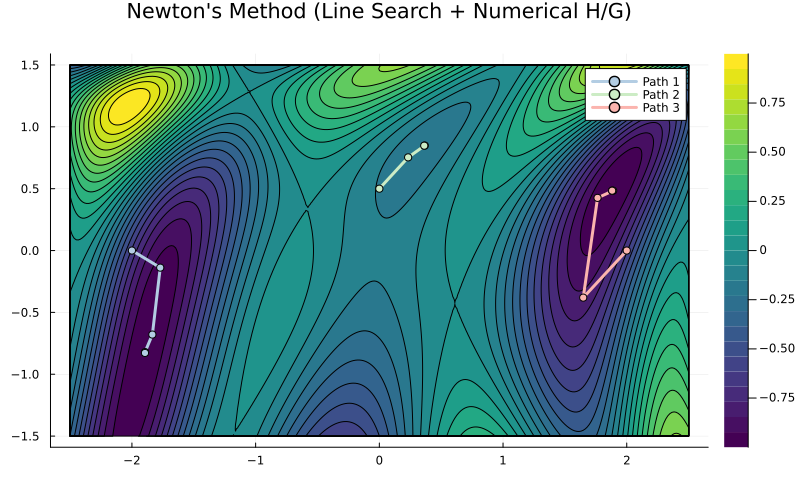

In [13]:
fplot(f)
plot!(title="Newton's Method (Line Search + Numerical H/G)")

# We'll use starting points that are a bit closer to the minima
x0s = [[-2.0, 0.0], [0.0, 0.5], [2.0, 0.0]]

for (i, x0) in enumerate(x0s)
    # Define the Newton search direction function!
    function search_dir(x)
        # 1. Get the numerical gradient and Hessian
        g = finite_difference_gradient(f, x)
        H = finite_difference_hessian(f, x)
        
        # 2. Solve the linear system: H * p = -g
        # This is the Newton step, p = -H \ g
        # (We add the negative sign, as the formula is p = -H_inv * g)
        return - (H \ g)
    end
    
    xs = line_search_optimizer(f, search_dir, x0)
    
    plot_path(xs, label="Path $i")
    println("Path $i: Length=$(length(xs)), ||gradient|| = $(sqrt(sum(∇f(xs[end]).^2)))")
end
fastdisplay()

# Look at the plots: The paths are very short and direct.
# The algorithm finds the minimum in just a few steps!